In [1]:
# Libraries

import numpy as np
from skimage.transform import resize
import pymartini
import rasterio
import pyvista as pv
from scipy.ndimage import map_coordinates
import settings
import utils

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib as matplot

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# plotting
import seaborn as sns
# for interactions
from mpl_toolkits.mplot3d import Axes3D

import TIN_engine
from TIN_engine import *
from TIN_draw import *
from TIN_drainage import *
from TIN_watershed import *
from TIN import *

# remove this (and possibly restart the kernel) if you don't want interactive plots
%matplotlib widget

# for reloading modules during development
%load_ext autoreload
%autoreload 2


# pysheds
from pysheds.grid import Grid

# other
import time
import copy

In [2]:
DATA_FILE = settings.WASHINGTON_SMALL
WATERSHED_POUR_POINT = (-116.52959, 49.229584)

In [3]:
# ---- Open Rasters ----
grid = Grid.from_raster(str(DATA_FILE))
dem = grid.read_raster(str(DATA_FILE))

# Watershed Delineation With TIN

In [4]:
# ---- Load DEM and create TIN ----
vertices_3d, triangles, xs, ys, zs, zs_scaled  = get_triangles_from_DEM(DATA_FILE, mesh_level=30)

Size:  795 -> 513 for Martini mesh generation


In [5]:
# ---- Get Highest Point ----
max_index = np.nanargmax(zs)
max_index = np.nanargmin(zs)
chosen_point = [xs[max_index], ys[max_index], zs[max_index]]
chosen_point

[np.float32(-116.58791), np.float32(49.169582), np.float32(0.0)]

In [6]:
# ---- Get Subset of Triangles Around Highest Point ----
radius = 0.2
bounds_around_highest = [chosen_point[0] + radius, chosen_point[1] + radius, chosen_point[0] - radius, chosen_point[1] - radius]

triangles_subset = get_subset_of_triangles_from_bounds(triangles, bounds_around_highest, xs, ys)

In [7]:
# ---- Convert to Triangle and Vertex Objects ----
triangle_objects, vertices = convert_to_triangle_and_vertex_objects(triangles_subset, xs, ys, zs)
print(len(triangle_objects), "triangle objects created.")
print(len(vertices), "vertex objects created.")

14431 triangle objects created.
7374 vertex objects created.


In [8]:
# ---- Preprocessing ----
has_flat_triangles(triangle_objects)
flat = get_flat_triangles(triangle_objects)
len(flat)
unflaten_triangles(triangle_objects)

In [9]:
# ~16 seconds for 18000 triangles

# ---- Drainage network calculation ----
drainage_outlet_nodes = create_drainage_network(triangle_objects)
print(len(drainage_outlet_nodes), "outlet nodes created.")

[TIN]: Error: not enough (or too many) triangles
Error: returning: No adjacent triangle found, stopping at iteration  3
[TIN]: Error: triangles do not share an edge (self.id: 4864, other_triangle.id: 4859, shared_vertices length: 1, are adjacent: False)
Error: last edge is None
[TIN]: Error: not enough (or too many) triangles
Error: returning: No adjacent triangle found, stopping at iteration  7
[TIN]: Error: not enough (or too many) triangles
Error: returning: No adjacent triangle found, stopping at iteration  1
ERROR: next_point should never be None
Error: returning: next_point should not be None, stopping at iteration  5
ERROR: next_point should never be None
Error: returning: next_point should not be None, stopping at iteration  3
[TIN]: Error: triangles do not share an edge (self.id: 6248, other_triangle.id: 6379, shared_vertices length: 1, are adjacent: False)
Error: last edge is None
[TIN]: Error: not enough (or too many) triangles
Error: returning: No adjacent triangle found, s

C:\Users\yamff\source\repos\cpts-475-watershed-delineation\notebooks\TIN_drainage.py:81: RuntimeWarning: invalid value encountered in divide
  descent = descent / np.linalg.norm(descent)
C:\Users\yamff\source\repos\cpts-475-watershed-delineation\venv\Lib\site-packages\numpy\linalg\_linalg.py:2431: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


394 outlet nodes created.


In [10]:
# ---- Watershed delineation ----
#watershed, start_node = delineate_watershed_from_outlet(drainage_outlet_nodes, WATERSHED_POUR_POINT)
watershed, start_node = delineate_random_watershed(drainage_outlet_nodes)

print(len(watershed), "triangles")

2 triangles


In [11]:
start_node.point
WATERSHED_POUR_POINT = (start_node.point[0], start_node.point[1])
WATERSHED_POUR_POINT

(np.float32(-116.42401), np.float32(49.366825))

Done drawing watershed triangles.
Done drawing drainage network.


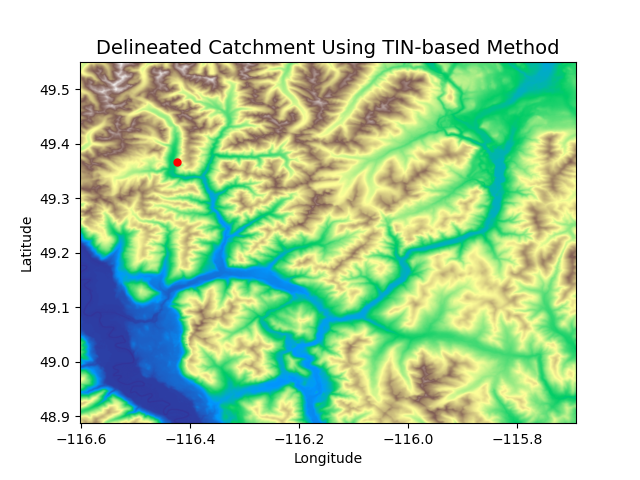

In [12]:
# ---- Visualize watershed ----

def draw_node(node: Node, depth, color):
    for upstream_node in node.upstream_nodes:
        draw_line_points(ax, node.point[0:2], upstream_node.point[0:2], color, linewidth=2)
        draw_node(upstream_node, depth + 1, color)

SHOW_DRAINAGE_NETWORK = True
SHOW_TIN_TRIANGLES = False

fig = plt.figure()
ax = fig.add_subplot(111)

# draw dem heat map
ax.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)

# draw triangles
if SHOW_TIN_TRIANGLES:
    norm = mcolors.Normalize(vmin=zs.min(), vmax=zs.max()) 
    scale_map = cm.ScalarMappable(cmap=cm.terrain, norm=norm)

    for triangle in triangle_objects:
        color = scale_map.to_rgba(triangle.get_centroid().z)
        draw_triangle_object(ax, triangle, color)

    print("Finished drawing terrain triangles.")

# draw watershed
for triangle in watershed:
    draw_triangle_object(ax, triangle, "#00ff0055", filled=True)

print("Done drawing watershed triangles.")

# draw drainage network
if SHOW_DRAINAGE_NETWORK:
    draw_node(start_node, 0, "#0000ff")
    draw_point(ax, start_node.point[0:2], markersize=5, color="#ff0000")

    print("Done drawing drainage network.")


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment Using TIN-based Method', size=14)
plt.show()

In [13]:
import csv
import uuid
import colorsys

# ---------------------------------------
# Color utility: evenly spaced colors
# ---------------------------------------
def generate_distinct_color(n, total):
    """Return hex color for watershed n of total."""
    hue = n / total
    r, g, b = colorsys.hsv_to_rgb(hue, 0.85, 0.95)
    return "#{:02x}{:02x}{:02x}".format(
        int(r * 255), int(g * 255), int(b * 255)
    )

# ---------------------------------------
# Node ID assignment
# ---------------------------------------
def get_node_id(node, node_id_map):
    if node not in node_id_map:
        node_id_map[node] = str(uuid.uuid4())
    return node_id_map[node]

# ---------------------------------------
# Upstream traversal for a single watershed
# ---------------------------------------
def traverse_upstream(node, visited, node_id_map, nodes, edges, watershed_id, color):
    node_id = get_node_id(node, node_id_map)

    if node_id not in nodes:
        x, y, z = node.point
        nodes[node_id] = {
            "id": node_id,
            "label": f"{watershed_id[:6]}-{node_id[:6]}",
            "x": x,
            "y": y,
            "z": z,
            "watershed_id": watershed_id,
            "color": color
        }

    visited.add(node)

    for up in node.upstream_nodes:
        up_id = get_node_id(up, node_id_map)

        edges.append({
            "source": up_id,
            "target": node_id,
            "watershed_id": watershed_id
        })

        if up not in visited:
            traverse_upstream(
                up, visited, node_id_map, nodes, edges, watershed_id, color
            )

# ---------------------------------------
# MAIN EXPORT FUNCTION
# ---------------------------------------
def export_watersheds_to_gephi(drainage_outlet_nodes, nodes_csv, edges_csv):
    node_id_map = {}
    all_nodes = {}
    all_edges = []

    num_ws = len(drainage_outlet_nodes)

    for i, pour_point in enumerate(drainage_outlet_nodes):
        watershed_id = f"WS_{i+1}"
        color = generate_distinct_color(i, num_ws)

        visited = set()
        traverse_upstream(
            node=pour_point,
            visited=visited,
            node_id_map=node_id_map,
            nodes=all_nodes,
            edges=all_edges,
            watershed_id=watershed_id,
            color=color
        )

    # ----- Write nodes.csv -----
    with open(nodes_csv, "w", newline='') as f:
        writer = csv.DictWriter(
            f,
            fieldnames=["id", "label", "x", "y", "z", "watershed_id", "color"]
        )
        writer.writeheader()

        for row in all_nodes.values():
            writer.writerow(row)

    # ----- Write edges.csv -----
    with open(edges_csv, "w", newline='') as f:
        writer = csv.DictWriter(
            f,
            fieldnames=["source", "target", "watershed_id"]
        )
        writer.writeheader()

        for e in all_edges:
            writer.writerow(e)

    print("Gephi export complete.")
    print(f"Total nodes: {len(all_nodes)}")
    print(f"Total edges: {len(all_edges)}")


In [14]:
export_watersheds_to_gephi(
    drainage_outlet_nodes,
    nodes_csv="nodes.csv",
    edges_csv="edges.csv"
)

Gephi export complete.
Total nodes: 23407
Total edges: 23013


In [15]:
import csv
import json
from shapely.geometry import Polygon, mapping
from collections import defaultdict
import numpy as np
from scipy.spatial import KDTree
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# --- 1) Build KD-tree of drainage outlets ---
node_points = np.array([[n.point[0], n.point[1]] for n in drainage_outlet_nodes])
tree = KDTree(node_points)

# --- 2) Assign watershed IDs to triangles ---
triangle_to_ws = {}
rows = []

for tri in triangle_objects:
    verts = tri.vertices()  # call method
    xs_tri = [v.x for v in verts]
    ys_tri = [v.y for v in verts]
    zs_tri = [v.z for v in verts]

    # Use lowest vertex to determine flow direction
    idx = np.argmin(zs_tri)
    x0, y0 = xs_tri[idx], ys_tri[idx]

    # Find nearest drainage outlet node
    dist, ws_id = tree.query([x0, y0])
    triangle_to_ws[tri.id] = ws_id

    # Store row for CSV
    row = {
        "triangle_id": int(tri.id),
        "x1": float(xs_tri[0]), "y1": float(ys_tri[0]), "z1": float(zs_tri[0]),
        "x2": float(xs_tri[1]), "y2": float(ys_tri[1]), "z2": float(zs_tri[1]),
        "x3": float(xs_tri[2]), "y3": float(ys_tri[2]), "z3": float(zs_tri[2]),
        "watershed_id": int(ws_id)
    }
    rows.append(row)

print("Assigned watershed IDs to", len(rows), "triangles.")

# --- 3) Write triangle CSV for Gephi ---
with open("triangle.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    writer.writeheader()
    writer.writerows(rows)
print("Wrote triangle.csv")

# --- 4) Build watershed polygons and GeoJSON ---
ws_polys = defaultdict(list)
for row in rows:
    poly = Polygon([(row["x1"], row["y1"]),
                    (row["x2"], row["y2"]),
                    (row["x3"], row["y3"])])
    ws_polys[row["watershed_id"]].append(poly)

def floatify_coords(obj):
    """Convert all coordinates to native Python float recursively."""
    if isinstance(obj, (list, tuple)):
        return [floatify_coords(x) for x in obj]
    elif isinstance(obj, dict):
        return {k: floatify_coords(v) for k, v in obj.items()}
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return float(obj)
    else:
        return obj

features = []
ws_color_map = {}
cmap = cm.get_cmap("tab20", len(ws_polys))  # color map
for i, (ws_id, polys) in enumerate(ws_polys.items()):
    merged = polys[0]
    for p in polys[1:]:
        merged = merged.union(p)
    geojson_geom = floatify_coords(mapping(merged))
    features.append({
        "type": "Feature",
        "properties": {
            "watershed_id": int(ws_id),
            "color": mcolors.to_hex(cmap(i))  # unique hex color
        },
        "geometry": geojson_geom
    })
    ws_color_map[ws_id] = mcolors.to_hex(cmap(i))

geo = {"type": "FeatureCollection", "features": features}
with open("watershed_polygons.geojson", "w") as f:
    json.dump(geo, f)
print("Wrote watershed_polygons.geojson with", len(features), "watersheds")

# --- 5) Build drainage edges CSV for Gephi ---
# Precompute triangle centroids
triangle_centroids = np.array([[tri.get_centroid().x, tri.get_centroid().y] for tri in triangle_objects])
triangle_ids = np.array([tri.id for tri in triangle_objects])
tri_tree = KDTree(triangle_centroids)

edges = []

for node in drainage_outlet_nodes:
    for upstream in node.upstream_nodes:
        # find nearest triangle centroid to upstream node
        dist, idx = tri_tree.query([upstream.point[0], upstream.point[1]])
        nearest_tri_id = triangle_ids[idx]
        ws_id = triangle_to_ws.get(nearest_tri_id, -1)

        edges.append({
            "source": id(upstream),
            "target": id(node),
            "watershed_id": int(ws_id),
            "color": ws_color_map.get(ws_id, "#0000ff")
        })

if edges:
    with open("drainage_edges.csv", "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(edges[0].keys()))
        writer.writeheader()
        writer.writerows(edges)
    print("Wrote drainage_edges.csv with", len(edges), "edges")
else:
    print("No drainage edges found")


Assigned watershed IDs to 14431 triangles.
Wrote triangle.csv


C:\Users\yamff\AppData\Local\Temp\ipykernel_38756\1263106082.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(ws_polys))  # color map


Wrote watershed_polygons.geojson with 384 watersheds
Wrote drainage_edges.csv with 1407 edges


NameError: name 'pd' is not defined

In [16]:
import pandas as pd

df = pd.read_csv("triangle.csv")
rows = []
for _, row in df.iterrows():
    for i in range(1, 4):  # x1,x2,x3 / y1,y2,y3
        rows.append({
            "x": row[f"x{i}"],
            "y": row[f"y{i}"],
            "watershed_id": row["watershed_id"]
        })

points_df = pd.DataFrame(rows)
points_df.to_csv("triangle_points.csv", index=False)

NameError: name 'pd' is not defined

In [52]:
# ---- Determine D8 flow directions from DEM ----

# ESRI scheme that specifies directions as numbers (which is the default)
"""
North: 64
Northeast: 128
East: 1
Southeast: 2
South: 4
Southwest: 8
West: 16
Northwest: 32
"""

#dirmap = (64, 128, 1, 2, 4, 8, 16, 32) # this is the default value
dirmap = (7, 8, 1, 2, 3, 4, 5, 6) # new value to make the D8 and Dinf plots the same
    
# Compute flow directions using D8
fdir = grid.flowdir(dem, dirmap=dirmap)

In [53]:
# ---- Flow Accumulation ----
acc = grid.accumulation(fdir, dirmap=dirmap)